# CNN - Style Transfer

利用CNN的特徵萃取特性把風格圖的風格轉移到目標圖案上

### Reference

[論文出處](https://arxiv.org/pdf/1508.06576v2.pdf)  

[原文論文github](https://github.com/keras-team/keras/blob/master/examples/neural_style_transfer.py)

簡單說就是，我們生成原圖的"結構"與期望結果的"結構"的損失函數，與風格圖的"風格"與期望結果的"風格"的損失函數  
利用這兩個損失函數的結合，經過訓練後，得到最小損失函數的特徵，再還原回去原圖，就得到我們要的結果。  

#### Step1. 基本設定

 - base_image_path: 原圖
 - style_reference_image_path: 風格圖
 - iterations: 共要訓練的次數
 - total_variation_weight: 擾動損失權重
 - style_weight: 風格損失函數權重
 - content_weight: 原圖損失函數權重

In [37]:
from __future__ import print_function
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import os
import matplotlib.pyplot as plt

from keras.applications import vgg19
from keras import backend as K

ROOT_DIR = os.getcwd()
STYLE_DIR = os.path.join(ROOT_DIR,'STYLE_TRANSFER')
base_image_path = os.path.join(STYLE_DIR,'origin2.jpg')
style_reference_image_path = os.path.join(STYLE_DIR,'style4.jpg')

result_prefix = 'image_create'
iterations = 20

# these are the weights of the different loss components
total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.02

這是方便之後畫圖使用

In [39]:
def show_img(img):
    plt.figure()
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

#### Step2. 資料處理定義

這裡有兩個函數的定義  
 * 第一為資料預處理，這個是把圖丟到VGG內的必經過程，size調整，歸一，與轉化為tensor
 * 第二為把最後得到的向量還原成圖

In [29]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# util function to open, resize and format pictures into appropriate tensors


def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# util function to convert a tensor into a valid image


def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))


#### Step3. 模型建立

這邊利用VGG19的模型，而輸入的tensor為3張圖像  
分別為: 原圖、風格參考圖、合成圖

In [45]:
# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')



Model loaded.


<tf.Tensor 'strided_slice_133:0' shape=(400, 600, 3) dtype=float32>

In [73]:
combination_image[0].flatten()

AttributeError: 'Tensor' object has no attribute 'flatten'

#### Step4. 數學模型

這邊的部分來自於論文

在風格損失函數方面，利用gram矩陣: 
![](https://i.imgur.com/sfabL04.jpg)

Gram矩陣為特性為提取，在由此計算來定義風格的損失函數:
![](https://i.imgur.com/Yk5o5Fg.jpg)

而內容的損失函數則是利用均方差計算:  
![](https://i.imgur.com/o4tHTL7.jpg)  

另外定義一個擾動損失，目的是為了讓產生圖有連貫性



In [31]:
# compute the neural style loss
# first we need to define 4 util functions

# the gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))



定義好損失函數以後  
在把損失函數加總  
  
在原圖上，是利用VGG19最後一層的Convolution來做損失評估  
原因是最後的層越有輸入的特徵形狀  
  
而在風格損失上，則是利用前面幾層的Convolution層的輸出來做評估  
原因是前幾層相較於整張圖的特徵  
對於簡單特徵上的擷取更為強烈表現  

![](https://i.imgur.com/Y4vKod9.jpg)

In [ ]:
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features,
                                      combination_features)


# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)


def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

損失定義

In [75]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

共作iterations次數得更新，來看看最後成果  
這裡利用的fmin_l_bfgs_b為Scipy的套件  
是利用L-BFGS做優化的函示，有待研究  
[參考資料](http://www.hankcs.com/ml/l-bfgs.html) 

In [32]:
for i in range(iterations+1):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix + '_at_iteration_%d.png' % i
    if (i%5==0):
        save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 2209800000.0
Image saved as image_create_at_iteration_0.png
Iteration 0 completed in 8s
Start of iteration 1
Current loss value: 1081485000.0
Image saved as image_create_at_iteration_1.png
Iteration 1 completed in 7s
Start of iteration 2
Current loss value: 809853200.0
Image saved as image_create_at_iteration_2.png
Iteration 2 completed in 7s
Start of iteration 3
Current loss value: 712064830.0
Image saved as image_create_at_iteration_3.png
Iteration 3 completed in 7s
Start of iteration 4
Current loss value: 657152100.0
Image saved as image_create_at_iteration_4.png
Iteration 4 completed in 7s
Start of iteration 5
Current loss value: 612814900.0
Image saved as image_create_at_iteration_5.png
Iteration 5 completed in 7s
Start of iteration 6
Current loss value: 585029100.0
Image saved as image_create_at_iteration_6.png
Iteration 6 completed in 7s
Start of iteration 7
Current loss value: 562800000.0
Image saved as image_create_at_iteration_7.png
It

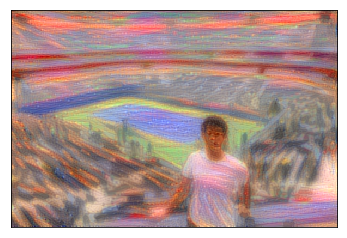

In [47]:

plt.figure()
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

In [49]:
type(img)

numpy.ndarray